In [39]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

%matplotlib inline

In [3]:
output_path = 'results.csv'
data = pd.read_csv(output_path)

In [4]:
data['project'] = data['benchmark'].apply(lambda x: x[:x.rindex('-')])

In [5]:
data_indexed = data.set_index(['tool', 'timeout', 'project'], drop=False).sort_index()

In [6]:
def get_weighted_stats(x, w=None, mn=None, mx=None, **kwargs):
    stats = DescrStatsW(x, w, ddof=1)

    q1, q2, q3 = stats.quantile([0.25, 0.5, 0.75], return_pandas=False)
    iqr = q3 - q1

    whishi = q3 + 1.5 * iqr
    if mx is not None:
        whishi = min(mx, whishi)

    whislo = q1 - 1.5 * iqr
    if mn is not None:
        whislo = max(mn, whislo)

    fliers = x.loc[(x > whishi) | (x < whislo)]

    return {
        'mean': stats.mean,
        'q1': q1,
        'med': q2,
        'q3': q3,
        'iqr': iqr,
        'whishi': whishi,
        'whislo': whislo,
        'fliers': list(fliers),
        'std': stats.std,
        **kwargs
    }


In [7]:
tools = list(data_indexed.index.unique(0))
timeouts = list(data_indexed.index.unique(1))
projects = list(data_indexed.index.unique(2))

In [8]:
def full_stats_dict():
    return {
        'default': None,
        'weighted': None,
    }


def compute_stats_by(df: pd.DataFrame, name: str, mod: str, weighted: bool) -> dict:
    label = f'{name}_{mod}'
    if weighted:
        label += ' (w)'
    return get_weighted_stats(
        df[f'{name}_{mod}_ratio'],
        df[f'{name}_total'] if weighted else None,
        mn=0, mx=100,
        label=label
    )


def compute_stats(df: pd.DataFrame, weighted: bool) -> dict:
    return {
        'lines_coverage': compute_stats_by(df, 'lines', 'coverage', weighted),
        'branches_coverage': compute_stats_by(df, 'branches', 'coverage', weighted),
        'mutants_coverage': compute_stats_by(df, 'mutants', 'coverage', weighted),
        'mutants_killed': compute_stats_by(df, 'mutants', 'killed', weighted),
    }


global_stats = defaultdict(
    lambda: defaultdict(
        lambda: {
            'projects': defaultdict(lambda: full_stats_dict()),
            **full_stats_dict()
        }
    )
)

for tool in tools:
    for timeout in timeouts:
        dt = data_indexed.loc[tool, timeout]
        stats = global_stats[tool][timeout]
        stats['default'] = compute_stats(dt, weighted=False)
        stats['weighted'] = compute_stats(dt, weighted=True)

        stats = stats['projects']
        for project in projects:
            dt = data_indexed.loc[tool, timeout, project]
            p_stats = stats[project]
            p_stats['default'] = compute_stats(dt, weighted=False)
            p_stats['weighted'] = compute_stats(dt, weighted=True)

In [9]:
table = pd.DataFrame(
    index=pd.MultiIndex.from_product([['ALL'] + projects, timeouts, tools], names=['project', 'timeout', 'tool']),
    columns=['lines', 'branches', 'mutants', 'mutants_killed', 'lines (w)', 'branches (w)', 'mutants (w)',
             'mutants_killed (w)']
)


def extract(x):
    return [x['lines_coverage']['mean'], x['branches_coverage']['mean'], x['mutants_coverage']['mean'],
            x['mutants_killed']['mean']]


for timeout in timeouts:
    for tool in tools:
        stats = global_stats[tool][timeout]
        item = [*extract(stats['default']), *extract(stats['weighted'])]
        table.loc['ALL', timeout, tool] = item
        for project in projects:
            stats = global_stats[tool][timeout]['projects'][project]
            item = [*extract(stats['default']), *extract(stats['weighted'])]
            table.loc[project, timeout, tool] = item

table

lines   branches    mutants mutants_killed  \
project  timeout tool                                                          
ALL      30      evosuite-mo  55.210458  49.894916  36.480681      36.378117   
         60      evosuite-mo  61.555651   55.66744  34.489519      33.563825   
         120     evosuite-mo  64.285031  58.740325  33.766544      32.880556   
FASTJSON 30      evosuite-mo  39.152513  32.622743  20.972063      20.972063   
         60      evosuite-mo  59.032202   53.15279  27.646341       24.92769   
         120     evosuite-mo  65.424631  59.984473  32.551468      30.106789   
GUAVA    30      evosuite-mo   61.19399  56.796202  58.969032      58.969032   
         60      evosuite-mo  69.623898  64.597746  62.616416      62.229943   
         120     evosuite-mo   69.41791  64.690254  53.308853      52.729143   
SEATA    30      evosuite-mo  63.595185  58.924183  38.909275       38.46483   
         60      evosuite-mo  66.689383  60.184006   41.99084       41.99084   
         120     evosuite-mo  63.796993  58.110493  42.902315      42.902315   
SPOON    30      evosuite-mo  62.252794  56.993928  32.241894      32.241894   
         60      evosuite-mo  51.718271  45.573435   7.985539       7.985539   
         120     evosuite-mo  58.120722  51.761366   6.708564       6.708564   

                              lines (w) branches (w) mutants (w)  \
project  timeout tool                                              
ALL      30      evosuite-mo  40.739353     38.41237   35.270735   
         60      evosuite-mo  48.911369    46.454177   42.126968   
         120     evosuite-mo  52.674743      47.7844   46.783311   
FASTJSON 30      evosuite-mo  34.376824    32.261752   20.582072   
         60      evosuite-mo   45.94279     40.80583   30.819954   
         120     evosuite-mo  51.576182    42.934705   39.702382   
GUAVA    30      evosuite-mo  56.649245    50.531915   68.780927   
         60      evosuite-mo  70.963995    77.186761   81.712237   
         120     evosuite-mo  69.454122    76.773049   87.176888   
SEATA    30      evosuite-mo  48.023115    41.864139   33.793103   
         60      evosuite-mo   46.22871     39.57346   33.463035   
         120     evosuite-mo  44.860097    38.704581   33.365571   
SPOON    30      evosuite-mo  43.096234     49.62963   29.690141   
         60      evosuite-mo   41.53417    44.135803   10.278885   
         120     evosuite-mo  47.921897    45.555557     7.24365   

                             mutants_killed (w)  
project  timeout tool                            
ALL      30      evosuite-mo          35.259991  
         60      evosuite-mo          40.564859  
         120     evosuite-mo          45.235532  
FASTJSON 30      evosuite-mo          20.582072  
         60      evosuite-mo          27.350917  
         120     evosuite-mo          36.458334  
GUAVA    30      evosuite-mo          68.780927  
         60      evosuite-mo          81.532945  
         120     evosuite-mo          86.872783  
SEATA    30      evosuite-mo          33.694581  
         60      evosuite-mo          33.463035  
         120     evosuite-mo          33.365571  
SPOON    30      evosuite-mo          29.690141  
         60      evosuite-mo          10.278885  
         120     evosuite-mo            7.24365

In [116]:
metrics = [
    'lines_coverage',
    'branches_coverage',
    'mutants_coverage',
    'mutants_killed',
]

print('tools:', ', '.join(tools))
print('timeouts:', ', '.join([str(x) for x in timeouts]))
print('projects:', ', '.join(projects))
print('metrics:', ', '.join(metrics))

tools: evosuite-mo
timeouts: 30, 60, 120
projects: FASTJSON, GUAVA, SEATA, SPOON
metrics: lines_coverage, branches_coverage, mutants_coverage, mutants_killed


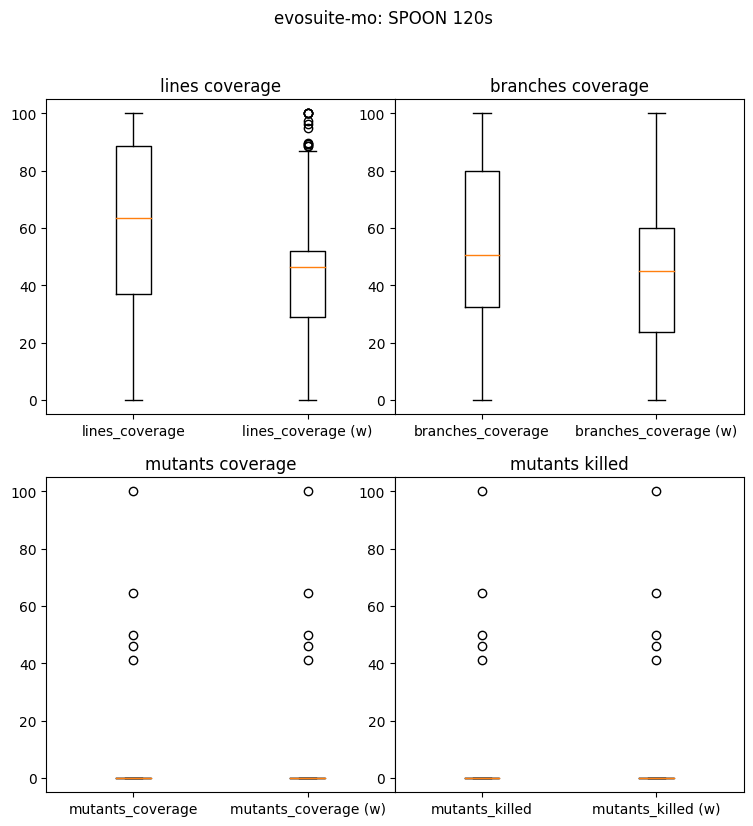

In [140]:
tool = 'evosuite-mo'
timeout = 120
project = 'SPOON'

fig = plt.figure(figsize=(9, 9))
gs = fig.add_gridspec(2, 2, wspace=0)
axes = gs.subplots()

fig.suptitle(f'{tool}: {timeout}s' if project is None else f'{tool}: {project} {timeout}s')

stats = global_stats[tool][timeout] if project is None else global_stats[tool][timeout]['projects'][project]

params = dict(
    widths = [0.2, 0.2],
)

axes[0][0].bxp([
    stats['default']['lines_coverage'],
    stats['weighted']['lines_coverage'],
], **params)
axes[0][0].set_title('lines coverage')

axes[0][1].bxp([
    stats['default']['branches_coverage'],
    stats['weighted']['branches_coverage'],
], **params)
axes[0][1].set_title('branches coverage')

axes[1][0].bxp([
    stats['default']['mutants_coverage'],
    stats['weighted']['mutants_coverage'],
], **params)
axes[1][0].set_title('mutants coverage')

axes[1][1].bxp([
    stats['default']['mutants_killed'],
    stats['weighted']['mutants_killed'],
], **params)
axes[1][1].set_title('mutants killed')

plt.show()

In [119]:
def get_cmap(n, name='brg'):
    return plt.colormaps.get_cmap(name).resampled(n)


def draw_boxplots(ax: plt.Axes, labels, mods, get_stats, width=0.07, gap=1):
    colors = get_cmap(len(mods))
    pos_diff = np.linspace(-1, 1, len(mods)) * width * (len(mods) // 2)
    x_tick_label = []
    x_tick_position = []

    for i, label in enumerate(labels):
        for j, mod in enumerate(mods):
            x_tick_label.append(label)
            x_tick_position.append(i * gap)
            p = i * gap + pos_diff[j]

            stats = get_stats(label, mod)
            bxp = ax.bxp([stats], widths=[width], patch_artist=True, positions=[p])
            for box in bxp["boxes"]:
                box.update(dict(
                    facecolor=colors(j),
                    zorder=.9,
                    edgecolor='gray',
                ))
            if i == 0:
                rect = plt.Rectangle((0, 0), 0, 0,
                                     linewidth=0,
                                     edgecolor='gray',
                                     facecolor=colors(j),
                                     label=mod)
                ax.add_patch(rect)

    plt.xticks(x_tick_position, x_tick_label)


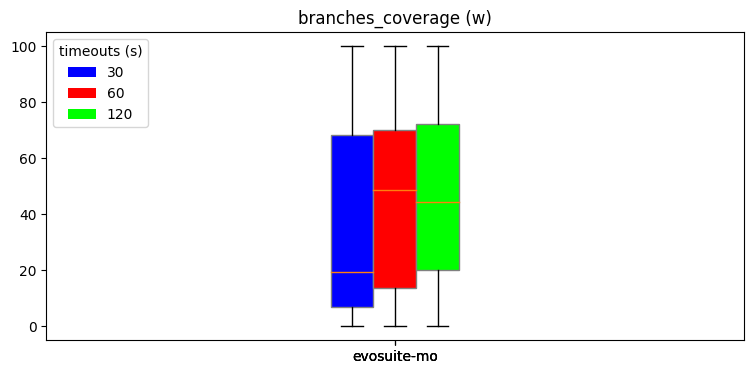

In [144]:
metric = 'branches_coverage'
weighted = True
project = None # or None

fig, ax = plt.subplots(figsize=(9, 4))

def get_stats(tool, timeout):
    stats = global_stats[tool][timeout] if project is None else global_stats[tool][timeout]['projects'][project]
    stats = stats['weighted'] if weighted else stats['default']
    return stats[metric]

draw_boxplots(ax, tools, timeouts, get_stats)

ax.legend(loc='upper left', title='timeouts (s)')
title = metric if project is None else f'{project}: {metric}'
if weighted:
    title += ' (w)'
ax.set_title(title)

plt.show()


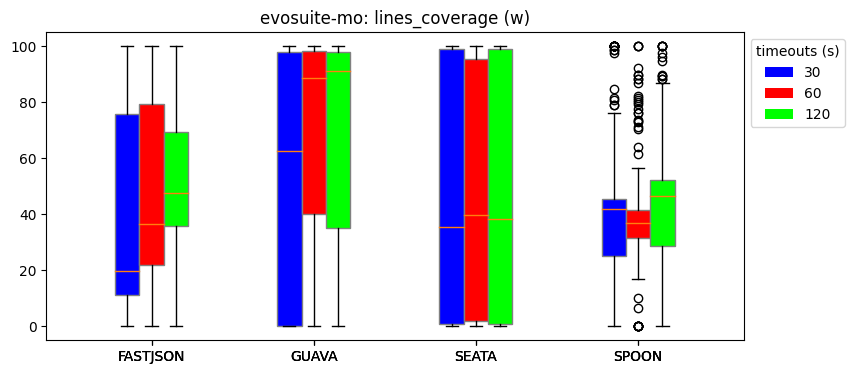

In [145]:
metric = 'lines_coverage'
weighted = True
tool = 'evosuite-mo'

fig, ax = plt.subplots(figsize=(9, 4))

def get_stats(project, timeout):
    stats = global_stats[tool][timeout]['projects'][project]
    stats = stats['weighted'] if weighted else stats['default']
    return stats[metric]

draw_boxplots(ax, projects, timeouts, get_stats, 0.15)

ax.legend(loc='upper left', title='timeouts (s)', bbox_to_anchor=(1, 1))
title = f'{tool}: {metric}'
if weighted:
    title += ' (w)'
ax.set_title(title)
plt.show()
